# Quora Quesiton Pairs

[Competition Homepage](https://www.kaggle.com/c/quora-question-pairs)

Currently, Quora uses a Random Forest model to identify duplicate questions. In this competition, Kagglers are challenged to tackle this natural language processing problem by applying advanced techniques to classify whether question pairs are duplicates or not. Doing so will make it easier to find high quality answers to questions resulting in an improved experience for Quora writers, seekers, and readers.

For each ID in the test set, Kagglers must predict the probability that the questions are duplicates (a number between 0 and 1).  Submissions are evaluated on the log loss between the predicted values and the ground truth.

## IMPORTS

In [3]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [4]:
import numpy as np
import pandas as pd
import multiprocessing as mp
import datetime as dt
import math
import os
import gc
import pickle

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import log_loss
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

from nltk.tokenize import RegexpTokenizer
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from imblearn.over_sampling import SMOTE

import xgboost as xgb

import gensim.models.doc2vec as d2v

C:\Users\CKhan\AppData\Local\Continuum\Anaconda3\lib\site-packages\gensim\utils.py:855: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [5]:
gc.collect()

171

## EDA

### Raw Data Analysis

In [35]:
for f in os.listdir('./data.gi'):
    if 'zip' not in f:
        print(f.ljust(30) + str(round(os.path.getsize('./data.gi/' + f) / 1000000, 2)) + ' MB')

.ipynb_checkpoints            0.0 MB
test.csv                      314.02 MB
train.csv                     63.4 MB


The competition provides 3 .csv files - training set, testing set, and sample submission.  It is interesting to note that the testing set is approximately 5x the size of the training set.  The [Data](https://www.kaggle.com/c/quora-question-pairs/data) section of the competition homepage states the following: 

*"As an anti-cheating measure, Kaggle has supplemented the test set with computer-generated question pairs. Those rows do not come from Quora, and are not counted in the scoring. All of the questions in the training set are genuine examples from Quora."*

The sample submission file can be ignored as it is just an example for Kagglers to follow when preparing their .csv files for submission.

### Training Set Analysis

**Train Columns:**
- **id:** (int) question pair identifier
- **qid1:** (int) single question identifer (first in pair)
- **qid2:** (int) single question identfier (second in pair)
- **question1:** (string) first question text
- **question2:** (string) second question text
- **is_duplicate:** (int) binary duplicate indicator - this is our label for supervised training

In [14]:
TRAIN = pd.read_csv('./data.gi/train.csv')
TRAIN.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [37]:
TRAIN.tail()

,id,qid1,qid2,question1,question2,is_duplicate
404285,404285,433578,379845,How many keywords are there in the Racket prog...,How many keywords are there in PERL Programmin...,0
404286,404286,18840,155606,Do you believe there is life after death?,Is it true that there is life after death?,1
404287,404287,537928,537929,What is one coin?,What's this coin?,0
404288,404288,537930,537931,What is the approx annual cost of living while...,I am having little hairfall problem but I want...,0
404289,404289,537932,537933,What is like to have sex with cousin?,What is it like to have sex with your cousin?,0


The last value in the *id* column matches the last row index value, indicating there are no jumps in ID.  The individual question IDs, however, do not appear to increase consistently.  Otherwise, we would expect *qid2* in row 404289 to be 808578.  Therefore, we will need to determine if the same questions are being used across pairs.

#### Duplicate Questions Across Pairs

Number of total questions:    537933
Number of unique questions:   426153
Number of repeated questions: 111780

Percent unique: 0.79%


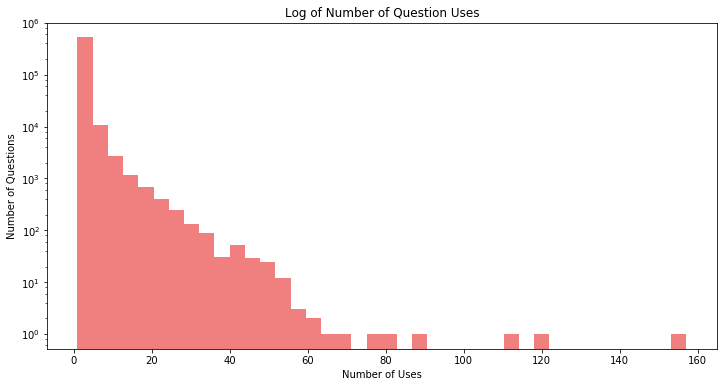

In [38]:
qid = TRAIN.qid1.tolist() + TRAIN.qid2.tolist()
qid_dict = dict.fromkeys(qid, 0)

for x in qid:
    qid_dict[x] += 1

unique = 0
for x in qid_dict:
    if qid_dict[x] == 1:
        unique += 1

total = len(qid_dict)
non_unique = total - unique

print('Number of total questions: '.ljust(30) + str(total))
print('Number of unique questions: '.ljust(30) + str(unique))
print('Number of repeated questions: '.ljust(30) + str(non_unique))
print('\nPercent unique: ' + '{0:.2f}%'.format(unique / total))

plt.figure(figsize=(12, 6))
plt.hist(pd.Series(qid).value_counts(), bins=40, log=True, color='lightcoral', label='train')
plt.xlabel('Number of Uses')
plt.ylabel('Number of Questions')
plt.title('Log of Number of Question Uses')
plt.show()

del qid, qid_dict, unique, total, non_unique

About 80% of questions are used only once, however, there are a number of quetions that are used many times.  There are also a few cases of outliers that are used 100+ times.

#### Class Imbalance of Pairs Labeled as Duplicate

Number of question pairs:     404290
Number of duplicates:         149263
Number of non-duplicates:     255027


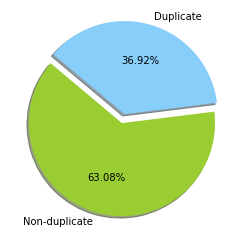

In [39]:
print('Number of question pairs: '.ljust(30) + str(len(TRAIN)))
print('Number of duplicates: '.ljust(30) + str(len(TRAIN[TRAIN.is_duplicate == 1])))
print('Number of non-duplicates: '.ljust(30) + str(len(TRAIN[TRAIN.is_duplicate == 0])))

plt.figure(figsize=(4, 4))
plt.pie(TRAIN.is_duplicate.value_counts(), explode=(0.1, 0), labels=('Non-duplicate', 'Duplicate'), colors=('yellowgreen', 'lightskyblue'), autopct='%1.2f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.show()

There is about a 2:1 class imbalance in favor of non-duplicate question pairs.  As a result, it will make sense to evaluate models on roc auc along with the log loss metric.

### Test Set Analysis

**Test Columns:**
- **test_id:** (int) question pair identifier
- **question1:** (string) first question text
- **question2:** (string) second question text

In [15]:
TEST = pd.read_csv('./data.gi/test.csv')
TEST.head()

,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?


In [41]:
TEST.tail()

,test_id,question1,question2
2345791,2345791,How do Peaks (TV series): Why did Leland kill ...,What is the most study scene in twin peaks?
2345792,2345792,"What does be ""in transit"" mean on FedEx tracking?",How question FedEx packages delivered?
2345793,2345793,What are some famous Romanian drinks (alcoholi...,Can a non-alcoholic restaurant be a huge success?
2345794,2345794,What were the best and worst things about publ...,What are the best and worst things examination...
2345795,2345795,What is the best medication equation erectile ...,How do I out get rid of Erectile Dysfunction?


There are no apparent incongruities in the *test_id* column as its final value matches the final index value.  Regarding computer-generated question pairs, test_id[4] appears to be an example with the two questions:
1. How "aberystwyth" start reading?
2. How their can I start reading?

It is also worthwhile pointing out that there is no straightforward way to determine if any questions are reused in the test set.

### Question Analysis

In [42]:
train_questions = TRAIN.question1.tolist() + TRAIN.question2.tolist()
test_questions = TEST.question1.tolist() + TEST.question2.tolist()

#### Missing Values

In [43]:
print('Train')
print('-----')
print('Question 1:'.ljust(30) + str(TRAIN.question1.isnull().sum()))
print('Question 2:'.ljust(30) + str(TRAIN.question2.isnull().sum()))
print('\nTest')
print('----')
print('Question 1:'.ljust(30) + str(TEST.question1.isnull().sum()))
print('Question 2:'.ljust(30) + str(TEST.question2.isnull().sum()))

Train
-----
Question 1:                   0
Question 2:                   2

Test
----
Question 1:                   2
Question 2:                   4


#### Word Count


Train Statistics
----------------
count    808580.000000
mean         11.064856
std           5.889168
min           1.000000
25%           7.000000
50%          10.000000
75%          13.000000
max         237.000000
dtype: float64

Test Statistics
---------------
count    4.691592e+06
mean     1.102431e+01
std      5.839925e+00
min      1.000000e+00
25%      7.000000e+00
50%      1.000000e+01
75%      1.300000e+01
max      2.380000e+02
dtype: float64


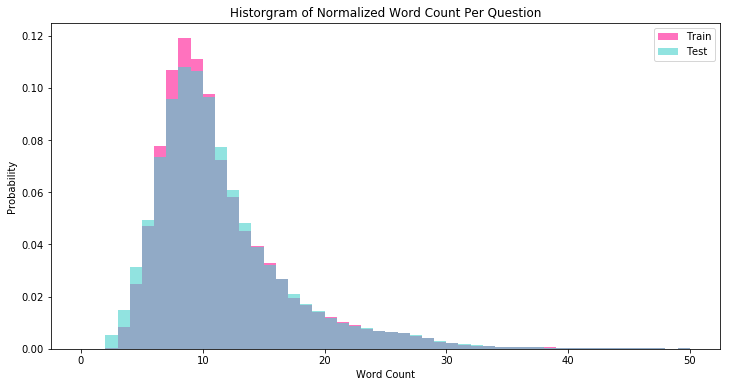

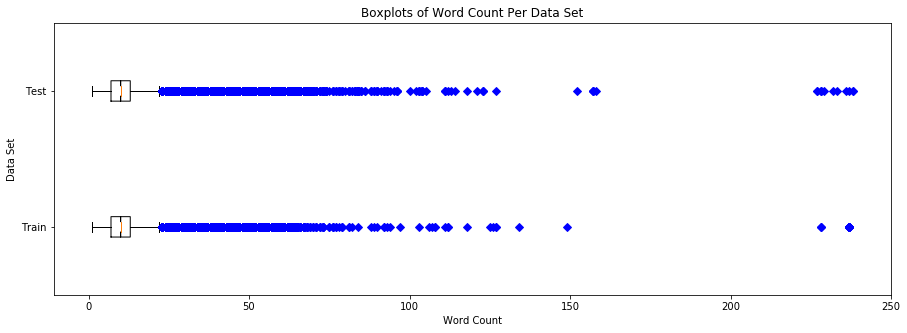

In [44]:
train_word_counts = pd.Series([len(str(x).split(' ')) for x in train_questions])
test_word_counts = pd.Series([len(str(x).split(' ')) for x in test_questions])

print('\nTrain Statistics')
print('----------------')
print(train_word_counts.describe())
print('\nTest Statistics')
print('---------------')
print(test_word_counts.describe())

plt.figure(figsize=(12,6))
plt.hist(train_word_counts, bins=50, range=[0, 50], color=('deeppink'), normed=True, alpha=0.6, label='Train')
plt.hist(test_word_counts, bins=50, range=[0, 50], color=('mediumturquoise'), normed=True, alpha=0.6, label='Test')
plt.xlabel('Word Count')
plt.ylabel('Probability')
plt.title('Historgram of Normalized Word Count Per Question')
plt.legend()
plt.show()

plt.figure(figsize=(15, 5))
plt.boxplot([train_word_counts, test_word_counts], True, 'bD', vert=False, labels=('Train', 'Test'))
plt.xlabel('Word Count')
plt.ylabel('Data Set')
plt.title('Boxplots of Word Count Per Data Set')
plt.show()

#### Character Count


TRAIN Statistics:
-----------------
count    808580.000000
mean         59.822548
std          31.963751
min           1.000000
25%          39.000000
50%          51.000000
75%          72.000000
max        1169.000000
dtype: float64

TEST Statistics:
----------------
count    4.691592e+06
mean     6.007010e+01
std      3.162463e+01
min      1.000000e+00
25%      4.000000e+01
50%      5.300000e+01
75%      7.200000e+01
max      1.176000e+03
dtype: float64


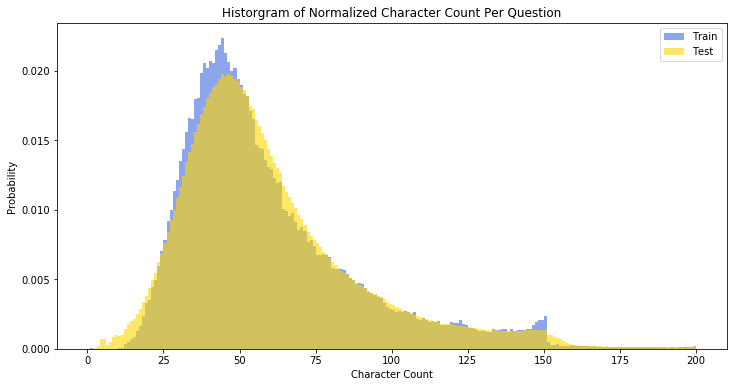

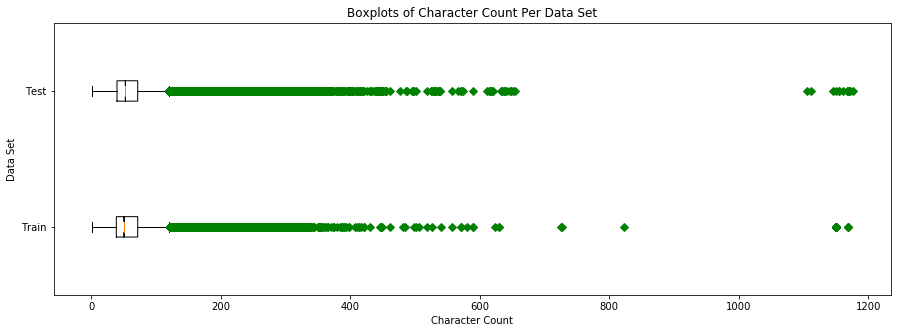

In [45]:
train_char_counts = pd.Series([len(str(x))for x in train_questions])
test_char_counts = pd.Series([len(str(x)) for x in test_questions])

print('\nTRAIN Statistics:')
print('-----------------')
print(train_char_counts.describe())
print('\nTEST Statistics:')
print('----------------')
print(test_char_counts.describe())

plt.figure(figsize=(12,6))
plt.hist(train_char_counts, bins=200, range=[0, 200], color=('royalblue'), normed=True, alpha=0.6, label='Train')
plt.hist(test_char_counts, bins=200, range=[0, 200], color=('gold'), normed=True, alpha=0.6, label='Test')
plt.xlabel('Character Count')
plt.ylabel('Probability')
plt.title('Historgram of Normalized Character Count Per Question')
plt.legend()
plt.show()

plt.figure(figsize=(15, 5))
plt.boxplot([train_char_counts, test_char_counts], True, 'gD', vert=False, labels=('Train', 'Test'))
plt.xlabel('Character Count')
plt.ylabel('Data Set')
plt.title('Boxplots of Character Count Per Data Set')
plt.show()

In [46]:
del train_questions, test_questions, train_word_counts, test_word_counts, train_char_counts, test_char_counts
gc.collect()

64454

### Feature Analysis

In [16]:
TRAIN_questions = TRAIN.question1.append(TRAIN.question2)
TEST_questions = TEST.question1.append(TEST.question2)

#### Text Preprocessing

In [56]:
# Tokenizing
tokenizer = RegexpTokenizer(r'\w+')
TRAIN_tokenized = TRAIN_questions.apply(lambda x: tokenizer.tokenize(str(x).lower()))
TRAIN_tokenized.to_pickle('./pickles.gi/TRAIN_tokenized.pkl')
TEST_tokenized = TEST_questions.apply(lambda x: tokenizer.tokenize(str(x).lower()))
TEST_tokenized.to_pickle('./pickles.gi/TEST_tokenized.pkl')
del tokenizer, TRAIN_tokenized, TEST_tokenized

In [58]:
# Stopword filtering
stopset = set(stopwords.words('english'))
TRAIN_tokenized = pd.read_pickle('./pickles.gi/TRAIN_tokenized.pkl')
TRAIN_filtered = TRAIN_tokenized.apply(lambda x: [w for w in x if w not in stopset])
TRAIN_filtered.to_pickle('./pickles.gi/TRAIN_filtered.pkl')
TEST_tokenized = pd.read_pickle('./pickles.gi/TEST_tokenized.pkl')
TEST_filtered = TEST_tokenized.apply(lambda x: [w for w in x if w not in stopset])
TEST_filtered.to_pickle('./pickles.gi/TEST_filtered.pkl')
del stopset, TRAIN_tokenized, TRAIN_filtered, TEST_tokenized, TEST_filtered

In [59]:
# Stemming (with and without stopword filtering)
stemmer = SnowballStemmer('english')

TRAIN_tokenized = pd.read_pickle('./pickles.gi/TRAIN_tokenized.pkl')
TRAIN_stemmed = TRAIN_tokenized.apply(lambda x: [stemmer.stem(w) for w in x])
TRAIN_stemmed.to_pickle('./pickles.gi/TRAIN_stemmed.pkl')
del TRAIN_tokenized, TRAIN_stemmed

TRAIN_filtered = pd.read_pickle('./pickles.gi/TRAIN_filtered.pkl')
TRAIN_stemmed_filtered = TRAIN_filtered.apply(lambda x: [stemmer.stem(w) for w in x])
TRAIN_stemmed_filtered.to_pickle('./pickles.gi/TRAIN_stemmed_filtered.pkl')
del TRAIN_filtered, TRAIN_stemmed_filtered

TEST_tokenized = pd.read_pickle('./pickles.gi/TEST_tokenized.pkl')
TEST_stemmed = TEST_tokenized.apply(lambda x: [stemmer.stem(w) for w in x])
TEST_stemmed.to_pickle('./pickles.gi/TEST_stemmed.pkl')
del TEST_tokenized, TEST_stemmed

TEST_filtered = pd.read_pickle('./pickles.gi/TEST_filtered.pkl')
TEST_stemmed_filtered = TEST_filtered.apply(lambda x: [stemmer.stem(w) for w in x])
TEST_stemmed_filtered.to_pickle('./pickles.gi/TEST_stemmed_filtered.pkl')
del TEST_filtered, TEST_stemmed_filtered, stemmer

In [61]:
# Lemmatizing (with and without stopword filtering)
lemmatizer = WordNetLemmatizer()

TRAIN_tokenized = pd.read_pickle('./pickles.gi/TRAIN_tokenized.pkl')
TRAIN_lemmatized = TRAIN_tokenized.apply(lambda x: [lemmatizer.lemmatize(w) for w in x])
TRAIN_lemmatized.to_pickle('./pickles.gi/TRAIN_lemmatized.pkl')
del TRAIN_tokenized, TRAIN_lemmatized

TRAIN_filtered = pd.read_pickle('./pickles.gi/TRAIN_filtered.pkl')
TRAIN_lemmatized_filtered = TRAIN_filtered.apply(lambda x: [lemmatizer.lemmatize(w) for w in x])
TRAIN_lemmatized_filtered.to_pickle('./pickles.gi/TRAIN_lemmatized_filtered.pkl')
del TRAIN_filtered, TRAIN_lemmatized_filtered

TEST_tokenized = pd.read_pickle('./pickles.gi/TEST_tokenized.pkl')
TEST_lemmatized = TEST_tokenized.apply(lambda x: [lemmatizer.lemmatize(w) for w in x])
TEST_lemmatized.to_pickle('./pickles.gi/TEST_lemmatized.pkl')
del TEST_tokenized, TEST_lemmatized

TEST_filtered = pd.read_pickle('./pickles.gi/TEST_filtered.pkl')
TEST_lemmatized_filtered = TEST_filtered.apply(lambda x: [lemmatizer.lemmatize(w) for w in x])
TEST_lemmatized_filtered.to_pickle('./pickles.gi/TEST_lemmatized_filtered.pkl')
del TEST_filtered, TEST_lemmatized_filtered, lemmatizer

In [17]:
# Combine preprocessed text into one dataframe
TRAIN_preprocessed_stacked = pd.DataFrame()
TRAIN_preprocessed_stacked['pid'] = TRAIN.id.append(TRAIN.id)
TRAIN_preprocessed_stacked['qid'] = TRAIN.qid1.append(TRAIN.qid2)
TRAIN_preprocessed_stacked['pos'] = pd.Series(np.full(len(TRAIN), 1)).append(pd.Series(np.full(len(TRAIN), 2))).reset_index(drop=True)
TRAIN_preprocessed_stacked['base'] = pd.read_pickle('./pickles.gi/TRAIN_tokenized.pkl')
TRAIN_preprocessed_stacked['filtered'] = pd.read_pickle('./pickles.gi/TRAIN_filtered.pkl')
TRAIN_preprocessed_stacked['stemmed'] = pd.read_pickle('./pickles.gi/TRAIN_stemmed.pkl')
TRAIN_preprocessed_stacked['stemmed_filtered'] = pd.read_pickle('./pickles.gi/TRAIN_stemmed_filtered.pkl')
TRAIN_preprocessed_stacked['lemmatized'] = pd.read_pickle('./pickles.gi/TRAIN_lemmatized.pkl')
TRAIN_preprocessed_stacked['lemmatized_filtered'] = pd.read_pickle('./pickles.gi/TRAIN_lemmatized_filtered.pkl')
TRAIN_preprocessed_stacked.reset_index(drop=True, inplace=True)
TRAIN_preprocessed_stacked.to_pickle('./pickles.gi/TRAIN_preprocessed_stacked.pkl')
del TRAIN_preprocessed_stacked

In [18]:
# Tagging for Doc2Vec processing
TRAIN_preprocessed_stacked = pd.read_pickle('./pickles.gi/TRAIN_preprocessed_stacked.pkl')
TRAIN_tagged = pd.DataFrame()
TRAIN_tagged['pid'] = TRAIN_preprocessed_stacked.pid
TRAIN_tagged['qid'] = TRAIN_preprocessed_stacked.qid
TRAIN_tagged['pos'] = TRAIN_preprocessed_stacked.pos
TRAIN_tagged['base'] = TRAIN_preprocessed_stacked.apply(lambda x: d2v.TaggedDocument(x['base'], x['qid']), axis=1)
TRAIN_tagged['filtered'] = TRAIN_preprocessed_stacked.apply(lambda x: d2v.TaggedDocument(x['filtered'], x['qid']), axis=1)
TRAIN_tagged['stemmed'] = TRAIN_preprocessed_stacked.apply(lambda x: d2v.TaggedDocument(x['stemmed'], x['qid']), axis=1)
TRAIN_tagged['stemmed_filtered'] = TRAIN_preprocessed_stacked.apply(lambda x: d2v.TaggedDocument(x['stemmed_filtered'], x['qid']), axis=1)
TRAIN_tagged['lemmatized'] = TRAIN_preprocessed_stacked.apply(lambda x: d2v.TaggedDocument(x['lemmatized'], x['qid']), axis=1)
TRAIN_tagged['lemmatized_filtered'] = TRAIN_preprocessed_stacked.apply(lambda x: d2v.TaggedDocument(x['lemmatized_filtered'], x['qid']), axis=1)
TRAIN_tagged.reset_index(drop=True, inplace=True)
TRAIN_tagged.to_pickle('./pickles.gi/TRAIN_tagged.pkl')
del TRAIN_preprocessed_stacked, TRAIN_tagged

In [19]:
print('DONE')

DONE


In [20]:
# Create unstacked version of TRAIN_preprocessed
stacked = pd.read_pickle('./pickles.gi/TRAIN_preprocessed_stacked.pkl')

,pid,qid_1,base_1,filtered_1,stemmed_1,stemmed_filtered_1,lemmatized_1,lemmatized_filtered_1,qid_2,base_2,filtered_2,stemmed_2,stemmed_filtered_2,lemmatized_2,lemmatized_filtered_2
0,0,1,"[what, is, the, step, by, step, guide, to, inv...","[step, step, guide, invest, share, market, india]","[what, is, the, step, by, step, guid, to, inve...","[step, step, guid, invest, share, market, india]","[what, is, the, step, by, step, guide, to, inv...","[step, step, guide, invest, share, market, india]",1,"[what, is, the, step, by, step, guide, to, inv...","[step, step, guide, invest, share, market, india]","[what, is, the, step, by, step, guid, to, inve...","[step, step, guid, invest, share, market, india]","[what, is, the, step, by, step, guide, to, inv...","[step, step, guide, invest, share, market, india]"
1,0,1,"[what, is, the, step, by, step, guide, to, inv...","[step, step, guide, invest, share, market, india]","[what, is, the, step, by, step, guid, to, inve...","[step, step, guid, invest, share, market, india]","[what, is, the, step, by, step, guide, to, inv...","[step, step, guide, invest, share, market, india]",2,"[what, is, the, step, by, step, guide, to, inv...","[step, step, guide, invest, share, market]","[what, is, the, step, by, step, guid, to, inve...","[step, step, guid, invest, share, market]","[what, is, the, step, by, step, guide, to, inv...","[step, step, guide, invest, share, market]"
2,0,2,"[what, is, the, step, by, step, guide, to, inv...","[step, step, guide, invest, share, market]","[what, is, the, step, by, step, guid, to, inve...","[step, step, guid, invest, share, market]","[what, is, the, step, by, step, guide, to, inv...","[step, step, guide, invest, share, market]",1,"[what, is, the, step, by, step, guide, to, inv...","[step, step, guide, invest, share, market, india]","[what, is, the, step, by, step, guid, to, inve...","[step, step, guid, invest, share, market, india]","[what, is, the, step, by, step, guide, to, inv...","[step, step, guide, invest, share, market, india]"
3,0,2,"[what, is, the, step, by, step, guide, to, inv...","[step, step, guide, invest, share, market]","[what, is, the, step, by, step, guid, to, inve...","[step, step, guid, invest, share, market]","[what, is, the, step, by, step, guide, to, inv...","[step, step, guide, invest, share, market]",2,"[what, is, the, step, by, step, guide, to, inv...","[step, step, guide, invest, share, market]","[what, is, the, step, by, step, guid, to, inve...","[step, step, guid, invest, share, market]","[what, is, the, step, by, step, guide, to, inv...","[step, step, guide, invest, share, market]"
4,1,3,"[what, is, the, story, of, kohinoor, koh, i, n...","[story, kohinoor, koh, noor, diamond]","[what, is, the, stori, of, kohinoor, koh, i, n...","[stori, kohinoor, koh, noor, diamond]","[what, is, the, story, of, kohinoor, koh, i, n...","[story, kohinoor, koh, noor, diamond]",3,"[what, is, the, story, of, kohinoor, koh, i, n...","[story, kohinoor, koh, noor, diamond]","[what, is, the, stori, of, kohinoor, koh, i, n...","[stori, kohinoor, koh, noor, diamond]","[what, is, the, story, of, kohinoor, koh, i, n...","[story, kohinoor, koh, noor, diamond]"


In [21]:
TRAIN_preprocessed_unstacked = stacked.merge(stacked, how='inner', on='pid', suffixes=('_1','_2'))

In [30]:
unstacked = TRAIN_preprocessed_unstacked

In [ ]:
unstacked = unstacked[(TRAIN_preprocessed_unstacked['qid_1'] != TRAIN_preprocessed_unstacked['qid_2]) & (documents_train['qid_x'] < documents_train['qid_y'])]

#### Word Share

In [ ]:
def calculate_word_share(q1, q2, tfidf_weights={}):
    if tfidf_weights:
        q1_shared = np.sum([tfidf_weights.get(x, 0) for x in q1 if x in q2])
        q2_shared = np.sum([tfidf_weights.get(x, 0) for x in q2 if x in q1])
        total = np.sum([tfidf_weights.get(x, 0) for x in q1]) + np.sum([tfidf_weights.get(x, 0) for x in q2])
    else:
        q1_shared = len([x for x in q1 if x in q2])
        q2_shared = len([x for x in q2 if x in q1])
        total = len(q1) + len(q2)
    if total == 0:
        return 0
    else:
        return (q1_shared + q2_shared) / total

In [ ]:
# Complete sentence
train_word_share = TRAIN.apply(calculate_word_share, axis=1, raw=True)

plt.figure(figsize=(15, 5))
plt.hist(train_word_share[TRAIN.is_duplicate == 1], bins=20, color=('forestgreen'), normed=True, alpha=0.6, label='Duplicate')
plt.hist(train_word_share[TRAIN.is_duplicate == 0], bins=20, color=('violet'), normed=True, alpha=0.6, label='Non-Duplicate')
plt.xlabel('Word Share')
plt.ylabel('Number of Question Pairs')
plt.title('Distribution of Question Pair Word Share')
plt.legend()
plt.show()

In [ ]:
# Stopword filtering
train_word_share_no_stopwords = TRAIN.apply(lambda x: calculate_word_share(x, stopwords.words('english')), axis=1, raw=True)

plt.figure(figsize=(15, 5))
plt.hist(train_word_share_no_stopwords[TRAIN.is_duplicate == 1], bins=20, color=('teal'), normed=True, alpha=0.6, label='Duplicate')
plt.hist(train_word_share_no_stopwords[TRAIN.is_duplicate == 0], bins=20, color=('orange'), normed=True, alpha=0.6, label='Non-Duplicate')
plt.xlabel('Word Share')
plt.ylabel('Number of Question Pairs')
plt.title('Distribution of Question Pair Word Share With Stopwords Excluded')
plt.legend()
plt.show()

In [ ]:
# Stemming
train_word_share_stemmed = TRAIN.apply(lambda x: calculate_word_share(x, stem=True), axis=1, raw=True)

plt.figure(figsize=(15, 5))
plt.hist(train_word_share_stemmed[TRAIN.is_duplicate == 1], bins=20, color=('teal'), normed=True, alpha=0.6, label='Duplicate')
plt.hist(train_word_share_stemmed[TRAIN.is_duplicate == 0], bins=20, color=('orange'), normed=True, alpha=0.6, label='Non-Duplicate')
plt.xlabel('Word Share')
plt.ylabel('Number of Question Pairs')
plt.title('Distribution of Question Pair Word Share with Stemming')
plt.legend()
plt.show()

In [ ]:
# Stopword filtering and stemming
train_word_share_no_stopwords_stemmed = TRAIN.apply(lambda x: calculate_word_share(x, stopwords.words('english'), True), axis=1, raw=True)

plt.figure(figsize=(15, 5))
plt.hist(train_word_share_no_stopwords_stemmed[TRAIN.is_duplicate == 1], bins=20, color=('teal'), normed=True, alpha=0.6, label='Duplicate')
plt.hist(train_word_share_no_stopwords_stemmed[TRAIN.is_duplicate == 0], bins=20, color=('orange'), normed=True, alpha=0.6, label='Non-Duplicate')
plt.xlabel('Word Share')
plt.ylabel('Number of Question Pairs')
plt.title('Distribution of Question Pair Word Share with Stopwords Excluded and Stemming')
plt.legend()
plt.show()

#### TF-IDF

In [ ]:
vectorizer = TfidfVectorizer()
TDX = vectorizer.fit_transform(TRAIN.question1.append(TRAIN.question2).fillna(''))

In [ ]:
weights_dict = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
weights_tuplst = list(zip(vectorizer.get_feature_names(), vectorizer.idf_))
weights_tuplst.sort(key=lambda x: x[1])

print('10 Most Frequent Terms')
print('----------------------')
print(weights_tuplst[:20])
print('\n10 Least Frequent Terms')
print('-----------------------')
print(weights_tuplst[len(weights_tuplst)-10:])

In [ ]:
print('Start: ', str(dt.datetime.now()))

tfidf_train_word_share = TRAIN.apply(lambda x: calculate_word_share(x, tfidf_weights=weights_dict), axis=1, raw=True)

plt.figure(figsize=(15, 5))
plt.hist(tfidf_train_word_share[TRAIN.is_duplicate == 1], bins=20, color=('teal'), normed=True, alpha=0.6, label='Duplicate')
plt.hist(tfidf_train_word_share[TRAIN.is_duplicate == 0], bins=20, color=('orange'), normed=True, alpha=0.6, label='Non-Duplicate')
plt.xlabel('Word Share (TF-IDF)')
plt.ylabel('Number of Question Pairs')
plt.title('Distribution of Question Pair Word Share (TF-IDF)')
plt.legend()
plt.show()

print('End: ', str(dt.datetime.now()))

#### Preprocess Test Data

In [ ]:
test_word_share_no_stopwords = TEST.apply(lambda x: calculate_word_share(x, stopwords.words('english')), axis=1, raw=True)
test_word_share_stemmed = TEST.apply(lambda x: calculate_word_share(x, stem=True), axis=1, raw=True)
test_word_share_no_stopwords_stemmed = TEST.apply(lambda x: calculate_word_share(x, stopwords.words('english'), True), axis=1, raw=True)

In [ ]:
test_vectorizer = TfidfVectorizer()
test_TDX = test_vectorizer.fit_transform(TEST.question1.append(TEST.question2).fillna(''))

test_weights_dict = dict(zip(test_vectorizer.get_feature_names(), test_vectorizer.idf_))
test_weights_tuplst = list(zip(test_vectorizer.get_feature_names(), test_vectorizer.idf_))
test_weights_tuplst.sort(key=lambda x: x[1])

print('10 Most Frequent Terms')
print('----------------------')
print(test_weights_tuplst[:20])
print('\n10 Least Frequent Terms')
print('-----------------------')
print(test_weights_tuplst[len(test_weights_tuplst)-10:])

tfidf_test_word_share = TEST.apply(lambda x: calculate_word_share(x, tfidf_weights=test_weights_dict), axis=1, raw=True)

#### ROC AUC Comparison

In [ ]:
print('Word Share Proportion')
print('---------------------')
print('Base:'.ljust(30), roc_auc_score(TRAIN.is_duplicate, train_word_share))
print('Filtered:'.ljust(30), roc_auc_score(TRAIN.is_duplicate, train_word_share_no_stopwords))
print('Stemmed:'.ljust(30), roc_auc_score(TRAIN.is_duplicate, train_word_share_stemmed))
print('Filtered & Stemmed:'.ljust(30), roc_auc_score(TRAIN.is_duplicate, train_word_share_no_stopwords_stemmed))
print('\nTF-IDF Weighting')
print('----------------')
print('Base:'.ljust(30), roc_auc_score(TRAIN.is_duplicate, tfidf_train_word_share))

## TRAINING

### Train-Test  Split

In [ ]:
X_train = pd.DataFrame()
X_test = pd.DataFrame()

X_train['word_share_base'] = train_word_share
X_train['word_share_no_stopwords'] = train_word_share_no_stopwords
X_train['word_share_stemmed'] = train_word_share_stemmed
X_train['word_share_no_stopwords_stemmed'] = train_word_share_no_stopwords_stemmed
X_train['word_share_tfidf'] = tfidf_train_word_share

X_test['word_share_base'] = TEST.apply(calculate_word_share, axis=1, raw=True)
X_test['word_share_no_stopwords'] = test_word_share_no_stopwords
X_test['word_share_stemmed'] = test_word_share_stemmed
X_test['word_share_no_stopwords_stemmed'] = test_word_share_no_stopwords_stemmed
X_test['word_share_tfidf'] = tfidf_test_word_share

y_train = TRAIN.is_duplicate.values

### Minority Class Over-Sampling

In [ ]:
# https://github.com/scikit-learn-contrib/imbalanced-learn
# https://beckernick.github.io/oversampling-modeling/

sm = SMOTE(random_state=12, ratio = 1.0)
X_train_smote, y_train_smote = sm.fit_sample(X_train, y_train)
print('Number of added samples: ', str(X_train_smote.shape[0] - X_train.shape[0]))

### Validation Set

In [ ]:
# Validation Set
X_training, X_validation, y_training, y_validation = train_test_split(X_train_smote, y_train_smote, test_size=0.2, random_state=42)

### XGBoost

In [ ]:
cores = mp.cpu_count() / 2

In [ ]:
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4
params['updater'] = 'grow_gpu'
params['nthread'] = cores

D_training = xgb.DMatrix(X_training, label=y_training)
D_validation = xgb.DMatrix(X_validation, label=y_validation)
watchlist = [(D_training, 'training'), (D_validation, 'validation')]

bst = xgb.train(params, D_training, 1000, watchlist, early_stopping_rounds=100, verbose_eval=50)

### Doc2Vec